In [37]:
import torch
import numpy as np
print(f"pytorch version: {torch.__version__}")
print(f"numpy version: {np.__version__}")

pytorch version: 1.8.1
numpy version: 1.19.2


### 1. Tensor Operations In Pytorch

In [23]:
# Create a 2D tensor (elements drawn from standard normal) 
# and then add a dimension of size 1 inserted at dimension 1
x = torch.empty((2, 2)).normal_(mean=0, std=1)
x1 = x.unsqueeze(1)
print(x1.shape)

torch.Size([2, 1, 2])


In [24]:
# Remove the extra dimension you just added to the previous tensor
x2 = x1.squeeze(1)
print(x2.shape)

torch.Size([2, 2])


In [32]:
# Create a random tensor of shape 5x3 uniformly drawn from the interval [3, 7)
y = torch.empty((5, 3)).uniform_(3, 7)
print(y)

tensor([[5.6293, 5.4502, 6.5026],
        [6.8094, 4.9756, 5.2988],
        [4.7589, 5.1045, 6.8203],
        [6.4683, 3.1541, 4.9187],
        [3.2700, 4.7172, 6.4032]])


In [31]:
# Retrieve the indices of all the non-zero elements in the tensor torch.Tensor([1, 1, 2, 0, 3])
z = torch.Tensor([1, 1, 2, 0, 3])
torch.nonzero(z)

tensor([[0],
        [1],
        [2],
        [4]])

In [35]:
# Create a random tensor of size (3,1) 
# and horizontally stack four copies together. (the result tensor shape is (3,4))
m = torch.randn(3,1)
m4 = m.expand(3,4)
m4

tensor([[ 0.2374,  0.2374,  0.2374,  0.2374],
        [ 0.3506,  0.3506,  0.3506,  0.3506],
        [-0.4111, -0.4111, -0.4111, -0.4111]])

### 2. Fully Connected Neural Network

I am using 500 neurons on the hidden layer 1, 100 neurons on the hidden layer 2. I also used "ReLU" for the activation function, which can overcome the vaishing gradient problem and allow a faster model. Emtropy loss was used to quickly eliminate the loss by minimizing the penalty caused by high probability of wrong assigned values. Further, Adam optimizer takes the advantages of adagrad and Rmseprop and takes good care of noise.  

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pandas as pd
import matplotlib.pyplot as plt

import random
import sys, os
import multiprocessing


In [43]:
# set up directory
data_dir = "/Users/yyt/Documents/Emory/Spring 2021/BIOS 534"
model_dir = "/Users/yyt/Documents/Emory/Spring 2021/BIOS 534"

In [49]:
# download dataset 
# 1. and decide on size

train_dataset = datasets.FashionMNIST(root=data_dir, train=True, transform=transforms.ToTensor(), download=True) 
test_dataset = datasets.FashionMNIST(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)
val_prop = 0.2

valid_size = int(val_prop*len(train_dataset))
train_size = len(train_dataset) - valid_size
test_size = len(test_dataset)

print("Number in training set:", train_size)
print("Number in validation set:", valid_size)
print("Number in testing set:", test_size)


Number in training set: 48000
Number in validation set: 12000
Number in testing set: 10000


In [55]:
# Split the training and validation set
train_dataset, valid_dataset = random_split(
    train_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(42))

In [88]:
# 2. FC network with 2 hidden layer - model specification
torch.manual_seed(42)
class Multiple_layer_fc_network(nn.Module):
    def __init__(self, input_size, num_classes, 
                 apply_dropout=False, dropout_p=0.50, apply_bn=False):
        super(Multiple_layer_fc_network, self).__init__()
        self.apply_dropout = apply_dropout
        self.apply_bn = apply_bn
        
        if self.apply_dropout:
            print(f"apply dropout with dropping rate {dropout_p}")
        if self.apply_bn:
            print(f"apply batch normalization")
        
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)
        self.bn1 = nn.BatchNorm1d(num_features=100)
        self.bn2 = nn.BatchNorm1d(num_features=50)
        self.dropout = nn.Dropout(p=dropout_p) # prob that the element to be zeroed
    
    def forward(self, x):
        # hidden layer 1
        x = self.fc1(x)
        if self.apply_bn:
            x = self.bn1(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)      
        # hidden layer 2
        x = self.fc2(x)
        if self.apply_bn:
            x = self.bn2(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)   
        # output layer
        x = self.fc3(x)
        return x

In [89]:
#  Global Variables Specification
input_size = 784 # 28*28=784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 50
num_workers = 4 #multiprocessing.cpu_count() 
apply_dropout = False
dropout_p = 0.20
apply_bn = True
early_stopping_criteria= 5

val_proportion = 0.2

saved_model_fn = os.path.join(model_dir, "best_fcn_model.pt")
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [90]:
# make sure the seed is working
t = [train_dataset[i][1] for i in range(10)]
print(t)

# check the dimensions of the data
image, target = train_dataset[0]
print("input image has shape:")
print(image.shape)

[9, 2, 5, 0, 5, 1, 3, 5, 0, 1]
input image has shape:
torch.Size([1, 28, 28])


In [91]:
# instantiate the model
clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.to(device) # move the model to gpu if available
print(clf)

# instantiate the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)
train_state = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

apply batch normalization
Multiple_layer_fc_network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [92]:
# train model
best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    correct = 0
    clf.train() # switch to training mode
    for batch_idx, (images, targets) in enumerate(train_loader):
        # transfer data to gpu if available
        images, targets = images.to(device), targets.to(device)
        #print(images.shape, targets.shape)
        
        # reshape the images to proper shape
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1) #(64, 1, 28, 28)->(64, 28*28)
        
        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1) #(64, 10)
        correct += (pred_labels==targets).sum().item()

        # print training stat every 200 steps
        if ((batch_idx+1) % 200==0):
            print(f"[epoch {epoch} step {batch_idx}] running training loss: {running_train_loss/200:.3f}")
            running_train_loss = 0.0
    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples
            
    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0 
    correct = 0
    for images, targets in valid_loader:
        images, targets = images.to(device), targets.to(device)
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1)
        preds = clf(images)
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['valid_loss'].append(epoch_val_loss)
    train_state['valid_acc'].append(epoch_val_acc)
    
    # early stopping
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        early_stopping_step = 0
        print(f"current best validation loss: {best_val_loss:.3f}")
        torch.save(clf.state_dict(), saved_model_fn)
        print("=====>save the best model")
    else:
        early_stopping_step += 1
        print(f"validation loss stops decreasing for {early_stopping_step} epoch")
        if (early_stopping_step==early_stopping_criteria):
            print("early stopping criteria reached")
            break
    print("--------------------------------------------")

[epoch 0 step 199] running training loss: 0.786
[epoch 0 step 399] running training loss: 0.465
[epoch 0 step 599] running training loss: 0.413
[epoch 0] val loss: 0.402, accuracy: 85.225%
current best validation loss: 0.402
=====>save the best model
--------------------------------------------
[epoch 1 step 199] running training loss: 0.356
[epoch 1 step 399] running training loss: 0.361
[epoch 1 step 599] running training loss: 0.352
[epoch 1] val loss: 0.378, accuracy: 86.317%
current best validation loss: 0.378
=====>save the best model
--------------------------------------------
[epoch 2 step 199] running training loss: 0.314
[epoch 2 step 399] running training loss: 0.326
[epoch 2 step 599] running training loss: 0.323
[epoch 2] val loss: 0.359, accuracy: 86.992%
current best validation loss: 0.359
=====>save the best model
--------------------------------------------
[epoch 3 step 199] running training loss: 0.285
[epoch 3 step 399] running training loss: 0.300
[epoch 3 step 59

In [93]:
# load the saved best model
clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.load_state_dict(torch.load(saved_model_fn))
clf.to(device)

# evaluate on testing set
clf.eval()
test_loss = 0.0
num_test_samples = 0 
correct = 0
for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1)
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")

apply batch normalization
testing loss: 0.336, testing accuracy: 88.250%


    train_loss  train_acc  valid_loss  valid_acc
0     0.526166   0.830625    0.401909   0.852250
1     0.356251   0.869646    0.378451   0.863167
2     0.320906   0.881208    0.358561   0.869917
3     0.295575   0.889521    0.327969   0.881667
4     0.275717   0.896146    0.337154   0.873167
5     0.257608   0.904229    0.347156   0.877167
6     0.248282   0.907146    0.319242   0.887333
7     0.235023   0.912229    0.329778   0.882250
8     0.220676   0.917063    0.327122   0.885583
9     0.211752   0.921104    0.357673   0.872500
10    0.205912   0.922771    0.325205   0.887167
11    0.196689   0.925562    0.347179   0.876667


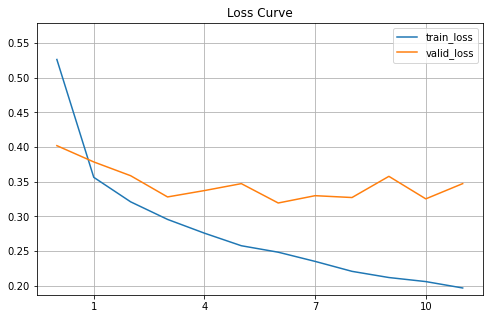

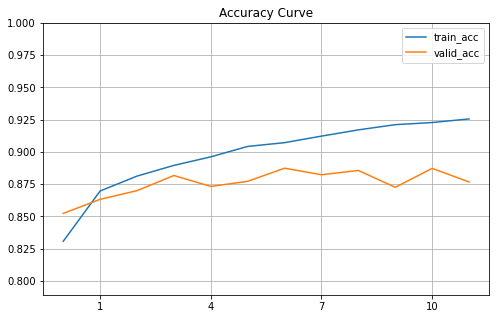

In [94]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()

train_state_df = pd.DataFrame(train_state)
print(train_state_df)
plot_learning_curves(train_state_df[['train_loss', 'valid_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'valid_acc']], "Accuracy Curve")

#### Add two more layers with 100 and 50 neurons respectively
The accuracy is 88.16%, almonst the same as the previous model (88.25%). As I add more layers to the model, it can make the model "memorize" the input data and result in overfitting--which can be found in the plot of accuracy, the accuracy of training set is a lot higher than that of the validation set. 


In [99]:
# Same features from previous model except adding 2 more hidden layers
torch.manual_seed(42)
class Multiple_layer_fc_network(nn.Module):
    def __init__(self, input_size, num_classes, 
                 apply_dropout=False, dropout_p=0.50, apply_bn=False):
        super(Multiple_layer_fc_network, self).__init__()
        self.apply_dropout = apply_dropout
        self.apply_bn = apply_bn
        
        if self.apply_dropout:
            print(f"apply dropout with dropping rate {dropout_p}")
        if self.apply_bn:
            print(f"apply batch normalization")
        
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, num_classes)
        self.bn1 = nn.BatchNorm1d(num_features=100)
        self.bn2 = nn.BatchNorm1d(num_features=50)
        self.bn3 = nn.BatchNorm1d(num_features=100)
        self.bn4 = nn.BatchNorm1d(num_features=50)
        self.dropout = nn.Dropout(p=dropout_p) # prob that the element to be zeroed
    
    def forward(self, x):
        # hidden layer 1
        x = self.fc1(x)
        if self.apply_bn:
            x = self.bn1(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)      
        # hidden layer 2
        x = self.fc2(x)
        if self.apply_bn:
            x = self.bn2(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)
        # hidden layer 3
        x = self.fc3(x)
        if self.apply_bn:
            x = self.bn3(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)
        # hidden layer 4
        x = self.fc4(x)
        if self.apply_bn:
            x = self.bn4(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)
        # output layer
        x = self.fc5(x)
        return x
    
    
# Global V Specification
input_size = 784 # 28*28=784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 50
num_workers = 4 #multiprocessing.cpu_count() 
apply_dropout = False
dropout_p = 0.20
apply_bn = True
early_stopping_criteria= 5

val_proportion = 0.2
 
saved_model_fn = os.path.join(model_dir, "best_fcn_model.pt")
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.to(device) # move the model to gpu if available
print(clf)

# instantiate the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    correct = 0
    clf.train() # switch to training mode
    for batch_idx, (images, targets) in enumerate(train_loader):
        # transfer data to gpu if available
        images, targets = images.to(device), targets.to(device)
        #print(images.shape, targets.shape)
        
        # reshape the images to proper shape
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1) #(64, 1, 28, 28)->(64, 28*28)
        
        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1) #(64, 10)
        correct += (pred_labels==targets).sum().item()
        # print training stat every 200 steps
        if ((batch_idx+1) % 200==0):
            print(f"[epoch {epoch} step {batch_idx}] running training loss: {running_train_loss/200:.3f}")
            running_train_loss = 0.0
    
    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples
            
    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0 
    correct = 0
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1)
        preds = clf(images)
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)
    
    # early stopping
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        early_stopping_step = 0
        print(f"current best validation loss: {best_val_loss:.3f}")
        torch.save(clf.state_dict(), saved_model_fn)
        print("=====>save the best model")
    else:
        early_stopping_step += 1
        print(f"validation loss stops decreasing for {early_stopping_step} epoch")
        if (early_stopping_step==early_stopping_criteria):
            print("early stopping criteria reached")
            break
    print("--------------------------------------------")

        
        

apply batch normalization
Multiple_layer_fc_network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=10, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[epoch 0 step 199] running training loss: 0.797
[epoch 0 step 399] running training loss: 0.476
[epoch 0 step 599] running training loss: 0.441
[epoch 0] val loss: 0.378, accuracy: 86.592%
current best validation loss: 0.378
=====>save the

In [101]:
# load the saved best model
clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.load_state_dict(torch.load(saved_model_fn))
clf.to(device)

# evaluate on testing set
clf.eval()
test_loss = 0.0
num_test_samples = 0 
correct = 0
for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1)
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")

apply batch normalization
testing loss: 0.326, testing accuracy: 88.160%


    train_loss  train_acc  val_loss   val_acc
0     0.540915   0.821063  0.378275  0.865917
1     0.371314   0.865563  0.351225  0.873667
2     0.333064   0.878229  0.365506  0.865000
3     0.309013   0.887000  0.339567  0.874333
4     0.292497   0.891333  0.322922  0.880333
5     0.278518   0.895833  0.318767  0.882833
6     0.264733   0.901771  0.308591  0.886917
7     0.252129   0.904896  0.320321  0.882917
8     0.240193   0.910479  0.361659  0.863917
9     0.228970   0.914937  0.336407  0.882250
10    0.223212   0.916729  0.357096  0.871917
11    0.211779   0.920562  0.334741  0.882500


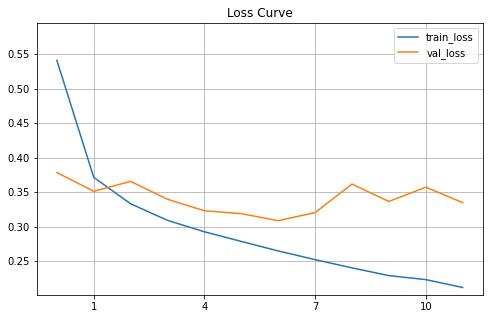

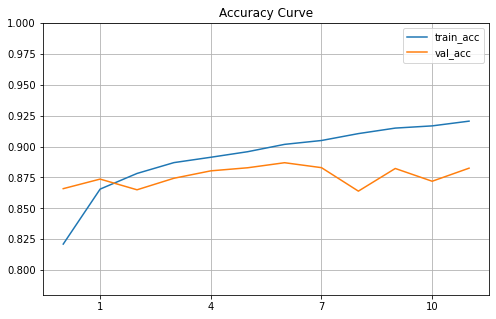

In [102]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()
train_state_df = pd.DataFrame(train_state)
print(train_state_df)
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")

#### Add dropout rate to the model to deal with overfitting. 
The dropout rate 0.2 is applied additionally to the 4 hidden layers. The accuracy turns out to be 87.96%. Without a compromise in the accuracy, the model with dropout improves the result by eliminating the overfitting. The final accuracy of the training set and the validation set is about the same. 
Dropout will randomly drop components from a single layer of neural network; therefore, the whole neural network has to incorporate more components and generalize the inputs. Thus, dropout will prevent overfitting by preventing the model from using a few data points. 
During testing phase, one needs to scale the activation or invert the dropout during the training phase to account the deactivated neurons during the training phase.

In [104]:
torch.manual_seed(42)
# Same features from previous model except adding 2 more hidden layers
torch.manual_seed(42)
class Multiple_layer_fc_network(nn.Module):
    def __init__(self, input_size, num_classes, 
                 apply_dropout=False, dropout_p=0.50, apply_bn=False):
        super(Multiple_layer_fc_network, self).__init__()
    
        self.apply_dropout = apply_dropout
        self.apply_bn = apply_bn
        
        if self.apply_dropout:
            print(f"apply dropout with dropping rate {dropout_p}")
        if self.apply_bn:
            print(f"apply batch normalization")
        
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, num_classes)
        self.bn1 = nn.BatchNorm1d(num_features=100)
        self.bn2 = nn.BatchNorm1d(num_features=50)
        self.bn3 = nn.BatchNorm1d(num_features=100)
        self.bn4 = nn.BatchNorm1d(num_features=50)
        self.dropout = nn.Dropout(p=dropout_p) # prob that the element to be zeroed
    
    def forward(self, x):
        # hidden layer 1
        x = self.fc1(x)
        if self.apply_bn:
            x = self.bn1(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)      
        # hidden layer 2
        x = self.fc2(x)
        if self.apply_bn:
            x = self.bn2(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)
        # hidden layer 3
        x = self.fc3(x)
        if self.apply_bn:
            x = self.bn3(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)
        # hidden layer 4
        x = self.fc4(x)
        if self.apply_bn:
            x = self.bn4(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)
        # output layer
        x = self.fc5(x)
        return x
    
    
# Global V Specification
input_size = 784 # 28*28=784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 50
num_workers = 4 #multiprocessing.cpu_count() 
apply_dropout = True
dropout_p = 0.20
apply_bn = True
early_stopping_criteria= 5

val_proportion = 0.2
 
saved_model_fn = os.path.join(model_dir, "best_fcn_model.pt")
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.to(device) # move the model to gpu if available
print(clf)

# instantiate the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    correct = 0
    clf.train() # switch to training mode
    for batch_idx, (images, targets) in enumerate(train_loader):
        # transfer data to gpu if available
        images, targets = images.to(device), targets.to(device)
        #print(images.shape, targets.shape)
        
        # reshape the images to proper shape
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1) #(64, 1, 28, 28)->(64, 28*28)
        
        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1) #(64, 10)
        correct += (pred_labels==targets).sum().item()
        # print training stat every 200 steps
        if ((batch_idx+1) % 200==0):
            print(f"[epoch {epoch} step {batch_idx}] running training loss: {running_train_loss/200:.3f}")
            running_train_loss = 0.0
    
    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples
            
    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0 
    correct = 0
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1)
        preds = clf(images)
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)
    
    # early stopping
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        early_stopping_step = 0
        print(f"current best validation loss: {best_val_loss:.3f}")
        torch.save(clf.state_dict(), saved_model_fn)
        print("=====>save the best model")
    else:
        early_stopping_step += 1
        print(f"validation loss stops decreasing for {early_stopping_step} epoch")
        if (early_stopping_step==early_stopping_criteria):
            print("early stopping criteria reached")
            break
    print("--------------------------------------------")

apply dropout with dropping rate 0.2
apply batch normalization
Multiple_layer_fc_network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=10, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[epoch 0 step 199] running training loss: 1.089
[epoch 0 step 399] running training loss: 0.629
[epoch 0 step 599] running training loss: 0.579
[epoch 0] val loss: 0.435, accuracy: 84.742%
current best 

In [105]:
# load the saved best model
clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.load_state_dict(torch.load(saved_model_fn))
clf.to(device)

# evaluate on testing set
clf.eval()
test_loss = 0.0
num_test_samples = 0 
correct = 0
for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1)
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")

apply dropout with dropping rate 0.2
apply batch normalization
testing loss: 0.336, testing accuracy: 87.960%


    train_loss  train_acc  val_loss   val_acc
0     0.723396   0.765854  0.434545  0.847417
1     0.508168   0.827187  0.389330  0.863500
2     0.460054   0.843583  0.357431  0.870833
3     0.429598   0.851375  0.351942  0.873667
4     0.413778   0.854875  0.358432  0.868833
5     0.398361   0.860812  0.342951  0.876917
6     0.384129   0.866375  0.350774  0.874000
7     0.371095   0.871354  0.328785  0.882750
8     0.363362   0.872021  0.332132  0.881917
9     0.351327   0.875000  0.336121  0.882083
10    0.346543   0.878271  0.327881  0.881667
11    0.339985   0.879938  0.315089  0.884500
12    0.337250   0.879625  0.318297  0.886167
13    0.328756   0.884188  0.322740  0.886417
14    0.323066   0.887417  0.318769  0.888750
15    0.319134   0.888854  0.322715  0.885500
16    0.312416   0.888583  0.319638  0.889500


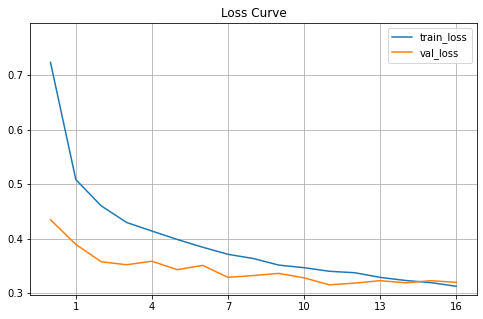

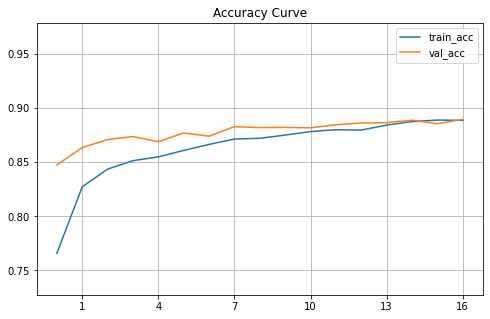

In [106]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()
train_state_df = pd.DataFrame(train_state)
print(train_state_df)
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")

### 3. Convolutional Neural Network
The CNN yields an accuracy of 90%, which is slightly better than the FC neural networks. The reasons for the improvement include (1) CNN assumes that the inputs are images, and thus performs better with this example of images; (2) the convolution units of CNN can reduce numbers of parameters to learn to avoid overfitting. 

In [109]:
class Conv_net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Conv_net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) #（1,28,28）->(6,26,26)
        x = self.pool(x) #(6,26,26)->(6,13,13)
        x = F.relu(self.conv2(x)) #（6,13,13）->(12,10,10)
        x = self.pool(x) #(12,10,10)->(12,5,5)
        x = x.view(-1, 12 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

x = torch.randn(64, 1, 28, 28)
model = Conv_net(in_channels=1, num_classes=10)
out = model(x)
print(out.shape)

num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 50
num_workers = 4 # multiprocessing.cpu_count() 
in_channels = 1 # fashion-mnist only has 1 channel
early_stopping_criteria= 5

val_proportion = 0.2
saved_model_fn = os.path.join(model_dir, "best_cnn_fmnist_model.pt")

train_dataset = datasets.FashionMNIST(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = datasets.FashionMNIST(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)


val_size = int(val_proportion*len(train_dataset))
train_size = len(train_dataset) - val_size
test_size = len(test_dataset)

print(f"number samples in train: {train_size}")
print(f"number samples in val: {val_size}")
print(f"number samples in test: {test_size}")

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_dataset, 
                                                           lengths=[train_size, val_size],
                                                           generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([64, 10])
number samples in train: 48000
number samples in val: 12000
number samples in test: 10000


In [110]:
# instantiate the model
clf = Conv_net(in_channels=in_channels, num_classes=num_classes)
clf.to(device) # move the model to gpu if available
print(clf)

# instantiate the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)
train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

Conv_net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [111]:
torch.manual_seed(42)
best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    correct = 0
    clf.train() # switch to training mode
    for batch_idx, (images, targets) in enumerate(train_loader):
        # transfer data to gpu if available
        images, targets = images.to(device), targets.to(device)
        #print(images.shape, targets.shape)
        
        # reshape the images to proper shape
        batch_size = images.shape[0]
        
        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()

        # print training stat every 200 steps
        if ((batch_idx+1) % 200==0):
            print(f"[epoch {epoch} step {batch_idx}] running training loss: {running_train_loss/200:.3f}")
            running_train_loss = 0.0
    
    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples
            
    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0 
    correct = 0
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)
        batch_size = images.shape[0]
        preds = clf(images)
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)
    
    # early stopping
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        early_stopping_step = 0
        print(f"current best validation loss: {best_val_loss:.3f}")
        torch.save(clf.state_dict(), saved_model_fn)
        print("=====>save the best model")
    else:
        early_stopping_step += 1
        print(f"validation loss stops decreasing for {early_stopping_step} epoch")
        if (early_stopping_step==early_stopping_criteria):
            print("early stopping criteria reached")
            break
    print("--------------------------------------------")

[epoch 0 step 199] running training loss: 1.111
[epoch 0 step 399] running training loss: 0.605
[epoch 0 step 599] running training loss: 0.533
[epoch 0] val loss: 0.490, accuracy: 82.100%
current best validation loss: 0.490
=====>save the best model
--------------------------------------------
[epoch 1 step 199] running training loss: 0.472
[epoch 1 step 399] running training loss: 0.433
[epoch 1 step 599] running training loss: 0.417
[epoch 1] val loss: 0.408, accuracy: 85.442%
current best validation loss: 0.408
=====>save the best model
--------------------------------------------
[epoch 2 step 199] running training loss: 0.367
[epoch 2 step 399] running training loss: 0.377
[epoch 2 step 599] running training loss: 0.368
[epoch 2] val loss: 0.378, accuracy: 86.700%
current best validation loss: 0.378
=====>save the best model
--------------------------------------------
[epoch 3 step 199] running training loss: 0.342
[epoch 3 step 399] running training loss: 0.341
[epoch 3 step 59

In [112]:
# load the saved best model
clf = Conv_net(in_channels=in_channels, num_classes=num_classes)
clf.load_state_dict(torch.load(saved_model_fn))
clf.to(device) # move the model to gpu if available

clf.eval()
test_loss = 0.0
num_test_samples = 0 
correct = 0
for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)
    batch_size = images.shape[0]
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")

testing loss: 0.274, testing accuracy: 90.020%


    train_loss  train_acc  val_loss   val_acc
0     0.699029   0.745167  0.489967  0.821000
1     0.430608   0.843917  0.407647  0.854417
2     0.368805   0.866500  0.378043  0.867000
3     0.336085   0.878938  0.333455  0.881083
4     0.313305   0.886958  0.322209  0.885917
5     0.295558   0.893333  0.309712  0.891917
6     0.281407   0.897042  0.304300  0.891750
7     0.271010   0.900854  0.291461  0.896667
8     0.259875   0.903729  0.280284  0.898833
9     0.253819   0.906104  0.292595  0.896667
10    0.243353   0.909687  0.275498  0.901667
11    0.235655   0.912458  0.308165  0.890583
12    0.231658   0.913792  0.270545  0.905000
13    0.223363   0.917312  0.260391  0.907583
14    0.218452   0.918583  0.271375  0.902583
15    0.210901   0.922625  0.270711  0.906000
16    0.207456   0.921667  0.269083  0.904583
17    0.201086   0.925208  0.261789  0.910083
18    0.195204   0.926979  0.266674  0.908083


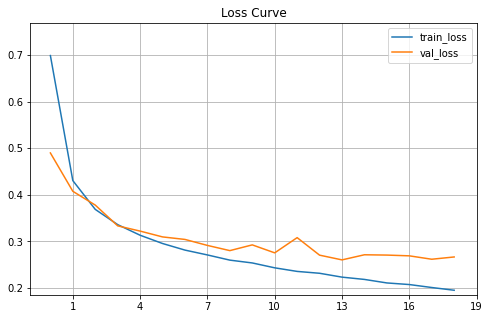

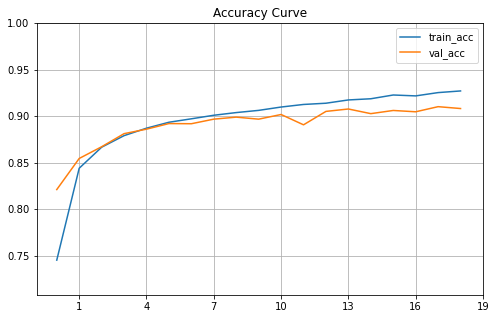

In [113]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()

train_state_df = pd.DataFrame(train_state)
print(train_state_df)
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")